In [1]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import torch
from anndata import AnnData
import seaborn as sns
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from PIL import Image
from collections import OrderedDict
from scipy.stats import pearsonr
import squidpy as sq
import timm
import itertools
import anndata as ad
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import itertools
from collections import Counter
import muon as mu

In [3]:
from pipelines.load import LoadCytAssistPipeline, LoadVisiumPipeline, LoadSeuratTonsilsPipeline
from pipelines.featurize import FeaturizePipeline
from pipelines.train import TrainModelPipeline
from pipelines.infer import InferencePipeline

from utils import cluster, align_adata, column_corr, floatify, tocpu, alpha_shape
from utils import alpha_shape

In [4]:
tissue = 'Tonsil'
antibody_panel = pd.read_csv('./antibody_panel.csv')
data_path = '/ix/hosmanbeyoglu/spicess_datasets/TonsilTissue'

train_loader = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX/filtered_feature_bc_matrix.h5',
    sample_id = 0,
    name = 'Tonsil 1',
)

eval_loader = LoadCytAssistPipeline(
    tissue=tissue, 
    h5_file=data_path+'/GEX_PEX_2/filtered_feature_bc_matrix.h5',
    sample_id = 1,
    name = 'Tonsil 2',
)

In [5]:
adata, pdata = train_loader.run() 
adata_eval, pdata_eval = eval_loader.run()

adata.shape, pdata.shape, adata_eval.shape, pdata_eval.shape

((4194, 18074), (4194, 30), (4908, 18074), (4908, 30))

In [6]:
sc.pp.filter_genes(adata, min_cells=5, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1500)
adata = adata[:, (adata.var['highly_variable'] 
                  | adata.var_names.isin(['PTPRC']+list(pdata.var_names)))]
adata.X = adata.layers['counts']

adata_eval = align_adata(adata_eval, adata)

In [7]:
trainer = TrainModelPipeline(
    tissue = 'Tonsil',
    adatas = [adata, adata_eval],
    pdatas = [pdata, pdata_eval],
    repeats = 1,
    latent_dim = 512,
    save = False,
    lr = 2e-5,
    dropout=0.1,
    use_histology=True,
    patience = 100,
    epochs = 9000,
    recons_gex = 1e-4, 
    recons_pex = 1e-4, 
    adj = 1e-3,
    align = 1e-4,
    minmax_vertical = True,
    min_max = True,
    gene_log = True,
    protein_log = False
)

spicess = trainer.run()

Created training pipeline.


Imput: 0.576 | SelfImput: 0.726 | Loss: 238 | Align: 0.00212 | :  97%|█████████▋| 8695/9000 [1:21:05<02:43,  1.86it/s, 1516d -> 512d || 5/100] IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
spicess.iter_0.results

,CORR_0
CD163,0.635123
CR2,0.549005
PCNA,0.482825
VIM,0.678344
KRT5,0.799471
CD68,0.477155
CEACAM8,0.294583
PTPRC_1,0.634381
PAX5,0.730388
SDC1,0.187718


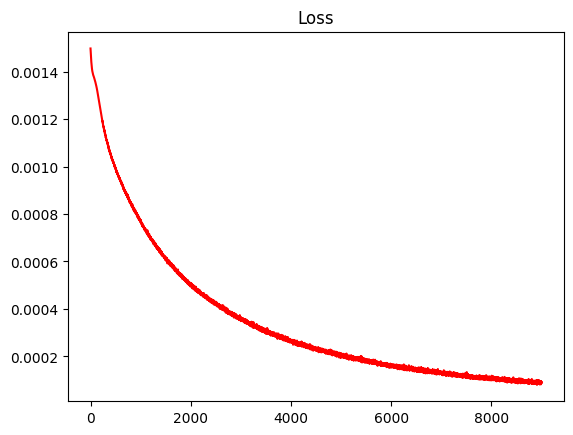

In [16]:
plt.plot(spicess.iter_0.metrics.values.mutual_info_loss, color='red')
plt.title('Loss')
plt.show()